In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
from pathlib import Path
import imghdr
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers


from keras.models import Sequential
from keras.layers import Dense,Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D 

from keras.applications import ResNet50

In [ ]:
data_dir = "/content/drive/MyDrive/CSELEC1A/CSELEC1AProject/Dataset1"


image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [ ]:
image_size = (200, 200)
batch_size = 64 #from 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 5200 files belonging to 4 classes.
Using 4160 files for training.
Found 5200 files belonging to 4 classes.
Using 1040 files for validation.


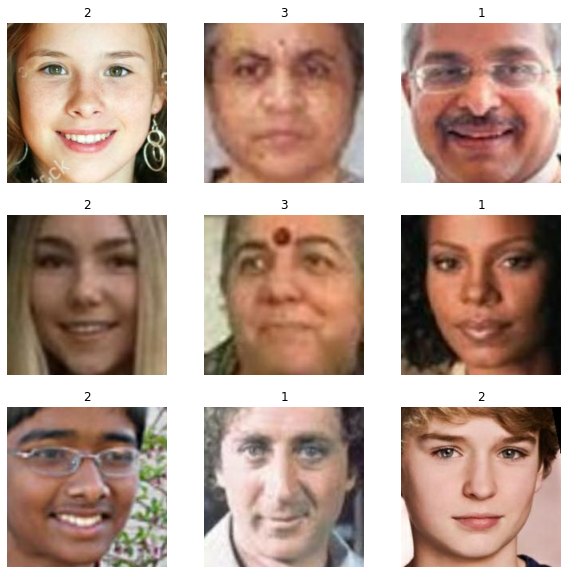

In [ ]:
# plot dataset example
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

In [ ]:
# load ResNet50 architecture
base_model=ResNet50(input_shape=image_size + (3,), weights="imagenet",include_top=False, classes=4) #removed , pooling='max'

# Freeze layers
layersFreezeNum = 200 #changed from the original 176
cnt = 0
for layers in base_model.layers:
    if cnt<layersFreezeNum:
        layers.trainable=False
    cnt+=1
print(cnt) # print total number of layers of architecture


x = base_model.output
x = Dropout(.5) (x)
x = GlobalAveragePooling2D() (x)
output = Dense(4,activation='softmax') (x)
model=tf.keras.Model(inputs=base_model.input,outputs=output)

94765736/94765736 [==============================] - 0s 0us/step
175


In [ ]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
65/65 [==============================] - 548s 8s/step - loss: 1.1255 - accuracy: 0.5125 - val_loss: 0.9008 - val_accuracy: 0.6240
Epoch 2/10
65/65 [==============================] - 19s 269ms/step - loss: 0.8960 - accuracy: 0.6284 - val_loss: 0.8421 - val_accuracy: 0.6433
Epoch 3/10
65/65 [==============================] - 17s 244ms/step - loss: 0.8222 - accuracy: 0.6649 - val_loss: 0.8092 - val_accuracy: 0.6692
Epoch 4/10
65/65 [==============================] - 17s 245ms/step - loss: 0.7917 - accuracy: 0.6849 - val_loss: 0.7829 - val_accuracy: 0.6808
Epoch 5/10
65/65 [==============================] - 17s 244ms/step - loss: 0.7575 - accuracy: 0.6930 - val_loss: 0.7724 - val_accuracy: 0.6846
Epoch 6/10
65/65 [==============================] - 17s 242ms/step - loss: 0.7239 - accuracy: 0.7099 - val_loss: 0.7597 - val_accuracy: 0.6913
Epoch 7/10
65/65 [==============================] - 17s 247ms/step - loss: 0.7066 - accuracy: 0.7272 - val_loss: 0.7572 - val_accuracy: 0.6971
E

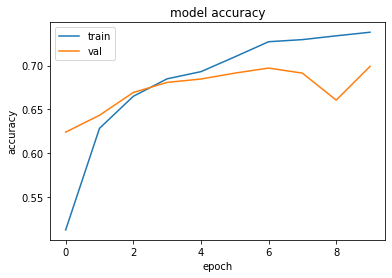

In [ ]:
# model accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

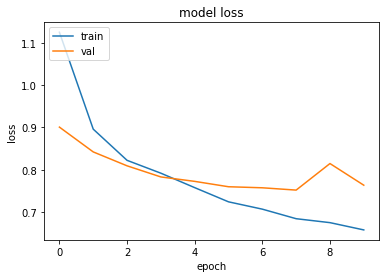

In [ ]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print("0 = 25-30, 1 = 42-48, 2 = 6-20, 3 = 60-98")
image_dir = data_dir + "/6-20/10_0_0_20161220222308131.jpg"
mg = keras.preprocessing.image.load_img(
    image_dir, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)